In [1]:
import os 
import numpy as np
import pandas as pd
import seaborn as sns 
from math import isnan
import multiprocessing

import matplotlib.pyplot as plt
from FeatureManager import *
from MyGraph import *

from graphframes import *

########## START - PYSPARK ##########
from pyspark import SparkContext, SparkConf

from pyspark.sql import SparkSession, SQLContext, Row
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.sql.functions import col, expr, count, to_timestamp, monotonically_increasing_id, \
    desc, sum as _sum, min, max, rand, when, \
    datediff, dayofmonth, weekofyear, month, year, hour, dayofweek, \
    unix_timestamp, array, lit

from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import StandardScaler, VectorAssembler, StringIndexer 
########## END - PYSPARK ##########

In [2]:
cores = multiprocessing.cpu_count()
instances = cores

spark = SparkSession.builder \
          .appName("MoneyLaundering") \
          .config("spark.driver.memory", "3g") \
          .config("spark.executor.memory", "4g") \
          .config("spark.executor.instances", cores) \
          .config("spark.executor.cores", cores//instances) \
          .config("spark.sql.shuffle.partitions", cores) \
          .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
          .config("spark.sql.execution.arrow.enabled", "true") \
          .getOrCreate()

spark.sparkContext.setLogLevel("OFF")
dataframe = spark.read.parquet("src/datasets/temporal_features.parquet", header=True)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/17 16:23:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
dataframe = dataframe.drop('id')
dataframe.printSchema()

root
 |-- hour: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- week: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- transactions_same_hour_fa: long (nullable = true)
 |-- transactions_same_day_fa: long (nullable = true)
 |-- transactions_same_week_fa: long (nullable = true)
 |-- transactions_same_hour_fata: long (nullable = true)
 |-- transactions_same_day_fata: long (nullable = true)
 |-- transactions_same_week_fata: long (nullable = true)
 |-- amount_received: double (nullable = true)
 |-- amount_paid: double (nullable = true)
 |-- same_amounts: integer (nullable = true)
 |-- same_account: integer (nullable = true)
 |-- same_bank: integer (nullable = true)
 |-- receiving_currency: double (nullable = true)
 |-- payment_currency: double (nullable = true)
 |-- same_currency: integer (nullable = true)
 |-- payment_format: double (nullable = true)
 |-- is_laundering: integer (nullable = true)



# Univariate Analysis

## SelectKBest (Pandas)

In [37]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X, y = dataframe.drop('is_laundering'), dataframe.select('is_laundering') 
bestfeatures = SelectKBest(score_func=chi2, k=len(X.columns))

X = X.toPandas()
y = y.toPandas()
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Column','Score']  

In [38]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
featureScores.sort_values(by='Score', ascending=False)

,Column,Score
11,amount_paid,1149484501000.525
10,amount_received,786433173910.994
6,transactions_same_week_fa,3704703.708
5,transactions_same_day_fa,916952.086
4,transactions_same_hour_fa,317864.593
9,transactions_same_week_fata,24444.616
7,transactions_same_hour_fata,4173.842
1,day_of_month,3535.868
8,transactions_same_day_fata,2277.683
0,hour,790.279


## Correlation Matrix

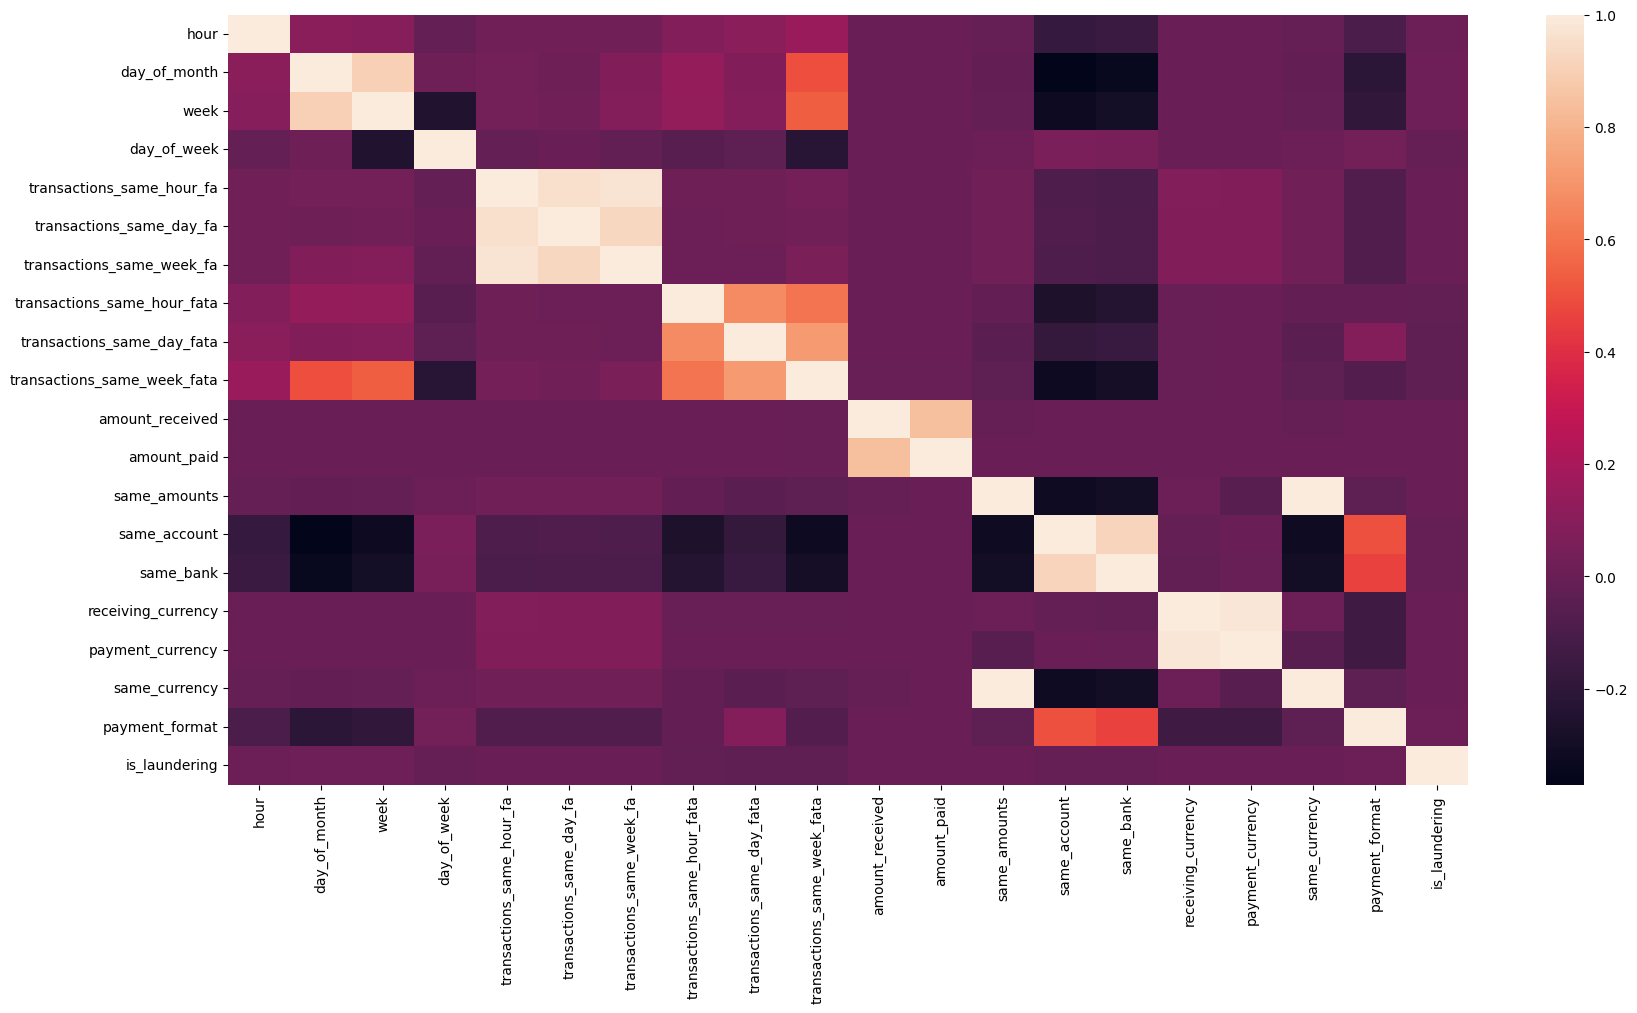

In [27]:
def correlation_matrix(df):     
    columns = df.columns
    assembler = VectorAssembler(inputCols=columns, outputCol="features")
    feature_vector = assembler.transform(df)

    matrix = Correlation.corr(feature_vector, "features").collect()[0][0]
    corr_matrix = np.array(matrix.toArray())

    plt.figure(figsize=(20, 10))
    sns.heatmap(corr_matrix, xticklabels=columns, yticklabels=columns)

corr = correlation_matrix(dataframe)

Vedendo la matrice di correlazione, vediamo che non c'è una diretta correlazione tra l'etichetta is_laundering e le varie feature. 


## PySpark

### ChiSqSelector
Metodo che lavora solo con gli interi

CI DEVO RIPROVARE

In [4]:
df = dataframe
df = df.drop('id','amount_received','amount_paid')

#df = df.withColumn('amount_received', col('amount_received').cast("float"))
#df = df.withColumn('amount_paid', col('amount_paid').cast("float"))
df = df.withColumn('receiving_currency', col('receiving_currency').cast("int"))
df = df.withColumn('payment_currency', col('payment_currency').cast("int"))
df = df.withColumn('payment_format', col('payment_format').cast("int"))
df = df.drop('amount_received','amount_paid')
cols = df.columns[:-1]

root
 |-- hour: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- week: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- transactions_same_hour_fa: long (nullable = true)
 |-- transactions_same_day_fa: long (nullable = true)
 |-- transactions_same_week_fa: long (nullable = true)
 |-- transactions_same_hour_fata: long (nullable = true)
 |-- transactions_same_day_fata: long (nullable = true)
 |-- transactions_same_week_fata: long (nullable = true)
 |-- same_amounts: integer (nullable = true)
 |-- same_account: integer (nullable = true)
 |-- same_bank: integer (nullable = true)
 |-- receiving_currency: integer (nullable = true)
 |-- payment_currency: integer (nullable = true)
 |-- same_currency: integer (nullable = true)
 |-- payment_format: integer (nullable = true)
 |-- is_laundering: integer (nullable = true)



In [8]:
from pyspark.ml.feature import VectorAssembler, ChiSqSelector
from pyspark.ml.classification import LogisticRegression

assembler = VectorAssembler(inputCols=cols, outputCol="features")
df_vector = assembler.transform(df)

selector = ChiSqSelector(numTopFeatures=2, featuresCol="features", outputCol="selectedFeatures", labelCol="is_laundering")

model = selector.fit(df_vector)
result = model.transform(df_vector)

train = result.select('is_laundering','selectedFeatures')

selected_feature_indices = model.selectedFeatures
selected_feature_names = [df.columns[i] for i in selected_feature_indices]
print("Selected features:", selected_feature_names)

Selected features: ['hour', 'day_of_month']


In [ ]:
feature_scores = model.pvalues

In [ ]:
from pyspark.ml.feature import VectorSlicer
from pyspark.ml.linalg import Vectors
from pyspark.sql.types import Row

df = spark.createDataFrame([
    Row(userFeatures=Vectors.sparse(3, {0: -2.0, 1: 2.3})),
    Row(userFeatures=Vectors.dense([-2.0, 2.3, 0.0]))])

slicer = VectorSlicer(inputCol="userFeatures", outputCol="features", indices=[1])

output = slicer.transform(df)

output.select("userFeatures", "features").show()


### Random Forest
https://www.timlrx.com/blog/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator

In [31]:
def extract_features(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    
    varlist = pd.DataFrame(list_extract)

    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))


In [33]:
from pyspark.ml.classification import RandomForestClassifier

df = dataframe
df = df.drop('id')

cols = df.columns[:-1]

assembler = VectorAssembler(inputCols=cols, outputCol="features")
df_vector = assembler.transform(df)

rf = RandomForestClassifier(labelCol="is_laundering", featuresCol="features", seed = 8464,
        numTrees=10, cacheNodeIds = True, subsamplingRate = 0.7)

pipe = Pipeline(stages = [rf])
mod = pipe.fit(df_vector)
df2 = mod.transform(df_vector)

SparseVector(19, {0: 0.0009, 1: 0.3501, 2: 0.2539, 3: 0.0167, 4: 0.0029, 5: 0.0026, 6: 0.0036, 7: 0.0115, 8: 0.0077, 9: 0.0129, 10: 0.0014, 11: 0.0043, 12: 0.039, 13: 0.0693, 14: 0.0896, 15: 0.001, 16: 0.0022, 17: 0.1068, 18: 0.0236})

In [34]:
selected_features = extract_features(mod.stages[-1].featureImportances, df2, "features")
selected_features

,idx,name,vals,score
1,1,day_of_month,NaN,0.350105
2,2,week,NaN,0.253928
15,17,same_currency,NaN,0.106804
14,14,same_bank,NaN,0.089569
13,13,same_account,NaN,0.069337
12,12,same_amounts,NaN,0.039034
18,18,payment_format,"[Cheque, Credit Card, ACH, Cash, Reinvestment,...",0.023624
3,3,day_of_week,NaN,0.016702
9,9,transactions_same_week_fata,NaN,0.012909
7,7,transactions_same_hour_fata,NaN,0.011477


In [193]:
threshold = 0.01
features = selected_features[selected_features['score']>=threshold][['name','score']].values.tolist()
new_features = []
feature_score = []
for feat in features: 
    new_features.append(feat[0])
    feature_score.append(feat[1])

In [194]:
new_features, '\n', feature_score

(['is_laundering', 'day_of_month', 'week', 'same_account'],
 '\n',
 [0.8746605646088832,
  0.044180512608197595,
  0.03868103915416466,
  0.012540189383633011])